In [260]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import tqdm
import pandas as pd

# os.environ['CUDA_VISIBLE_DEVICES'] = ''

from keras_transfer_learning import data, utils, model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TODOs:

* read https://arxiv.org/pdf/1805.12462.pdf

In [4]:
print('\n'.join(utils.utils.list_model_names()))

P/cityscapes/dsb2018/stardist/resnet-unet/002/000
P/cityscapes/dsb2018/stardist/resnet-unet/005/000
P/cityscapes/dsb2018/stardist/resnet-unet/010/000
P/cityscapes/dsb2018/stardist/resnet-unet/050/000
P/cityscapes/dsb2018/stardist/resnet-unet/200/000
P/cityscapes/hl60low/stardist/resnet-unet/002/000
P/cityscapes/hl60low/stardist/resnet-unet/005/000
P/cityscapes/hl60low/stardist/resnet-unet/010/000
P/cityscapes/hl60low/stardist/resnet-unet/050/000
P/cityscapes/hl60low/stardist/resnet-unet/200/000
P/dsb2018/cityscapes/segm/resnet-unet/002/000
P/dsb2018/cityscapes/segm/resnet-unet/005/000
P/dsb2018/cityscapes/segm/resnet-unet/010/000
P/dsb2018/cityscapes/segm/resnet-unet/050/000
P/dsb2018/cityscapes/segm/resnet-unet/200/000
P/dsb2018/granulocyte/fgbg-weighted/resnet-unet/002/000
P/dsb2018/granulocyte/fgbg-weighted/resnet-unet/005/000
P/dsb2018/granulocyte/fgbg-weighted/resnet-unet/010/000
P/dsb2018/granulocyte/fgbg-weighted/resnet-unet/050/000
P/dsb2018/granulocyte/fgbg-weighted/resnet-une

## Distances for specific models and datasets

In [ ]:
def compute_distance_for(model_name, dataset_name):
    # Get the model config
    model_config = utils.utils.yaml_load(utils.utils.path_to_model_config(model_name))
    # Get the data config
    data_config = utils.utils.yaml_load(os.path.join('configs', 'data', dataset_name + '.yaml'))
    # Compute the fenchet model distance
    return data.compare.frenchet_model_distance(model_config, data_config, 'activation_1')

In [ ]:
compute_distance_for(model_name='R/none/dsb2018/stardist/unet/F/000', 
                     dataset_name='hl60_low-noise')

In [ ]:
compute_distance_for(model_name='R/none/hl60low/stardist/unet/F/000', 
                     dataset_name='dsb2018')

In [ ]:
compute_distance_for(model_name='R/none/granulocyte/stardist/unet/F/000', 
                     dataset_name='dsb2018')

## Distances for pretrained models

In [237]:
def distance_for_model(model_name, feature_layer_name='activation_1', distance_metrics=['gmm'], num_samples=20):
    # Get the model config
    p_model_config = utils.utils.yaml_load(utils.utils.path_to_model_config(model_name))

    # Get the pretrain model
    weights_file = p_model_config['backbone']['weights']
    r_model_config = utils.utils.yaml_load(os.path.join(weights_file.rpartition(os.path.sep)[0], 'config.yaml'))

    return data.compare.model_distance(r_model_config,
                                       p_model_config['data'],
                                       feature_layer_name,
                                       distance_metrics,
                                       num_samples)

In [238]:
def improvement_for_model(model_name, metric='ap_dsb2018#mean'):
    name_parts = utils.utils.split_model_name(model_name)

    # Get the models trained with random init
    data_name = name_parts[utils.utils.DATA_NAME]
    head_name = name_parts[utils.utils.HEAD_NAME]
    backbone_name = name_parts[utils.utils.BACKBONE_NAME]
    num_train = name_parts[utils.utils.NUM_TRAIN_NAME]
    r_model_name_pattern = f'R/none/{data_name}/{head_name}/{backbone_name}/{num_train:03d}/.*'
    r_model_names = utils.utils.list_model_names(pattern=r_model_name_pattern)
    
    # Mean of the results from the random init
    r_results = utils.visualize._get_results_last(r_model_names, metric)
    r_result_mean = np.mean(list(r_results.values()))
    
    # Result of the pretrained model
    p_result = utils.visualize._get_results_last([model_name], metric)[model_name]
    return p_result - r_result_mean

In [253]:
model_names = utils.utils.list_model_names(pattern='P/.*/dsb2018/stardist/unet/(002|005|010)/.*')

In [266]:
model_distances = []
improvements = []

for model_name in model_names:
    model_distances.append(distance_for_model(model_name, feature_layer_name='features_up2_relu2'))
    improvements.append(improvement_for_model(model_name))

100%|██████████| 20/20 [00:00<00:00, 20.28it/s]


In [267]:
df = pd.DataFrame({'model_name': model_names,
              'distance': [d[0] for d in model_distances],
              'improvement': improvements})

In [270]:
df[df['model_name'].str.contains('/002/')]

,model_name,distance,improvement
0,P/granulocyte/dsb2018/stardist/unet/002/000,201.013670,-0.001222
1,P/granulocyte/dsb2018/stardist/unet/002/001,200.793833,-0.000600
2,P/granulocyte/dsb2018/stardist/unet/002/002,203.182122,0.002298
3,P/granulocyte/dsb2018/stardist/unet/002/003,201.100783,-0.001576
4,P/granulocyte/dsb2018/stardist/unet/002/004,212.976483,-0.001680
15,P/hl60low/dsb2018/stardist/unet/002/000,96.681161,-0.003277
16,P/hl60low/dsb2018/stardist/unet/002/001,67.220783,-0.001238
17,P/hl60low/dsb2018/stardist/unet/002/002,38.447193,-0.006535
18,P/hl60low/dsb2018/stardist/unet/002/003,53.195323,-0.003748
19,P/hl60low/dsb2018/stardist/unet/002/004,117.362161,-0.002231


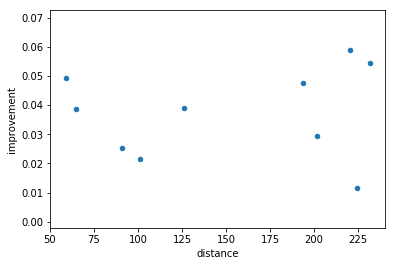

In [273]:
df[df['model_name'].str.contains('/010/')].plot.scatter(x='distance', y='improvement')

In [ ]:
model_name = 'C{:02d}_unet_stardist_dsb2018_R_F'
dataset_name = 'granulocyte'
distances = [compute_distance_for(model_name.format(i), dataset_name) for i in range(5)]

In [ ]:
import seaborn as sns
import pandas as pd

sns.barplot(x=list(range(5)), y=distances)

## Tests with KL

In [41]:
res = []
for i in range(50):
    res.append(distance_for_model('P/dsb2018/granulocyte/stardist/unet/002/002',
                       distance_metrics=['gmm_kl'],
                       num_samples=[1,2,3,4,5])[0])
res = np.array(res)
print(res)
print(np.mean(res))
print(np.std(res))

100%|██████████| 5/5 [00:00<00:00, 11.58it/s]


[ 1825.01819122   633.59652077  1032.21324035  1662.57033405
   639.02065875  1010.48665914  1890.67562793  1440.05945812
   613.08828472  1384.38519439   633.85486072   607.80119776
   642.31271602  1379.65531062  1592.44967097  1551.20208628
   614.63327627  1870.76914406  1170.59044527  1098.42127527
  1260.79406682  1178.82409313 64007.68610448  1055.41540204
   610.28471604   613.63663331  1180.81799234   902.3461854
  1685.48347193   633.14933199   611.9966659    650.96158992
  1727.44036709  1652.03227934  1697.35027304   629.20842804
   635.4113857   1557.39101987  1838.39744909  1657.28630432
  1603.6381305   1869.83009437   625.53160687  1125.93485884
  1864.36733101  1229.41620976  1636.98432054   612.3053246
  1423.5677092    909.34612781]
2439.5927925195983
8807.357914109574


In [54]:
distance_for_model('P/dsb2018/hl60low/stardist/unet/002/004',
                   distance_metrics=['gmm_js'],
                   num_samples=[1,2,3,4,5])

100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


[502.88615582 502.84276621 488.16384043 ... 217.74412271 221.83270346
 228.29728742]
[423.57643116 442.75886566 422.36975046 ... 278.20178421 274.17927769
 289.02024231]


[0.3465735902799736]

In [236]:
distance_for_model('P/dsb2018/granulocyte/stardist/unet/002/002',
                   distance_metrics=['gmm'])[0]

100%|██████████| 20/20 [00:01<00:00, 11.57it/s]


235.34714619399685

In [145]:
np.mean(gmm.predict_proba(features_2))

0.2

In [225]:
probs = np.exp(gmm.score_samples(features_2))

In [226]:
np.mean(probs)

2.0073713251611296e+147

In [171]:
gmm.score_samples([features_2[0]])

array([135.85208689])

In [166]:
np.max(probs)

348.16533841427673

In [169]:
np.exp(probs)

array([9.99566493e+058, 7.02364424e+101, 1.01057875e+103, ...,
       5.45410305e+083, 6.00987657e+111, 2.90416924e+090])

/home/benjamin/miniconda3/envs/bachelorthesis/lib/python3.6/site-packages/scipy/stats/stats.py:2275: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis)
/home/benjamin/miniconda3/envs/bachelorthesis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benjamin/miniconda3/envs/bachelorthesis/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/benjamin/miniconda3/envs/bachelorthesis/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/benjamin/miniconda3/envs/bachelorthesis/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'whiskers': [<matplotlib.lines.Line2D at 0x7fec2c0a21d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fec2c0a2860>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fec2c0a2080>],
 'medians': [<matplotlib.lines.Line2D at 0x7fec2c0a2ef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fec2c0bb278>],
 'means': []}

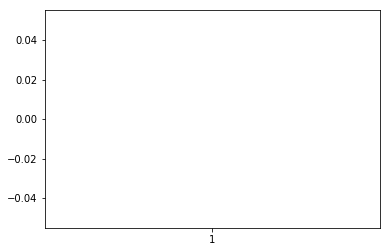

In [223]:
plt.boxplot(probs)

In [133]:
res = []
for i in range(10):
    res.append(distance_for_model('P/dsb2018/granulocyte/stardist/unet/002/002',
                       distance_metrics=['gmm'],
                       num_samples=20)[0])
res = np.array(res)
print(res)
print(np.mean(res))
print(np.std(res))

100%|██████████| 20/20 [00:01<00:00, 11.43it/s]


[286.85239205 283.14037717 273.79011963 249.87588215 276.60956081
 264.34653383 287.56297685 281.75710307 269.31835155 272.14692593]
274.54002230354763
10.942162804653282


In [112]:
from scipy import stats

z = np.abs(stats.zscore(scores))

In [118]:
scores_no_outliers = scores[z <= 3]

In [122]:
z_2 = np.abs(stats.zscore(scores_no_outliers))
scores_no_outliers_2 = scores_no_outliers[z_2 <= 3]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fec9283deb8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fec92802588>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fec9283dd68>],
 'medians': [<matplotlib.lines.Line2D at 0x7fec92802c18>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fec92802f60>],
 'means': []}

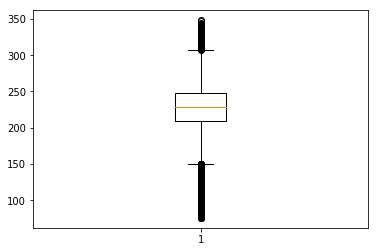

In [123]:
import matplotlib.pyplot as plt

plt.boxplot(scores_no_outliers_2)

In [73]:
np.mean(gmm_a.score_samples(X))

383.95347125557544

In [28]:
bic = [-5124056.947580278, -6088970.0099516455, -7825165.432037428, -7541669.380319952, -7961211.454268431, -8132447.96610913, -8048465.72341832, -8064394.772778989, -8066623.199008973, -8027243.637015863, -7963164.449253852]
bic = np.array(bic)
bic = (bic - np.mean(bic)) / np.std(bic)
bic

array([ 2.55308827,  1.52968071, -0.31176553, -0.01108352, -0.45605887,
       -0.637676  , -0.54860263, -0.56549732, -0.56786084, -0.52609402,
       -0.45813026])

In [30]:
bic = [-5007589.102622675, -6224901.243342034, -7619813.843778, -7931046.694660291, -8385922.17452652, -8038983.586599671, -8092124.714317061, -8084928.199852173, -8019096.164722523, -8107589.84585533, -8246948.496297529]
bic = np.array(bic)
bic = (bic - np.mean(bic)) / np.std(bic)
bic

array([ 2.62376264,  1.39855773, -0.00539916, -0.31864998, -0.77647477,
       -0.42728671, -0.48077239, -0.47352922, -0.40727034, -0.49633779,
       -0.63660001])

In [32]:
bic = [-5067327.377639387, -6149177.571574167, -6135147.923640884, -7854867.531895772, -8361792.998926982, -7971268.567160127, -8022159.973261829, -8029429.965285071, -8402821.074355008, -8037221.63878229, -8308260.545259206]
bic = np.array(bic)
bic = (bic - np.mean(bic)) / np.std(bic)
bic

array([ 2.22399027,  1.22897569,  1.24187924, -0.33980562, -0.80604229,
       -0.44686363, -0.4936702 , -0.50035666, -0.84377721, -0.50752292,
       -0.75680666])

In [34]:
bic = [-5067327.377639387, -6149177.571574167, -7762021.634738796, -7854605.951378641, -8067440.98683827, -7966434.796300796, -7982433.514507938, -7979442.48704604, -8060149.147563323, -7940601.490216804, -7936329.151462341]
bic = np.array(bic)
bic = (bic - np.mean(bic)) / np.std(bic)
bic

array([ 2.6256627 ,  1.46947801, -0.2541854 , -0.35313123, -0.58059027,
       -0.4726439 , -0.48974189, -0.48654535, -0.57279741, -0.44503557,
       -0.44046968])

In [37]:
bic = [-5053016.8329620585, -6193154.734473263, -6052897.074340915, -7929287.008064644, -8384702.154626688, -8065046.524682592, -8032085.538988901, -8124441.895739372, -8067481.297958793, -8015460.98675337, -8289538.2403924875]
bic = np.array(bic)
bic = (bic - np.mean(bic)) / np.std(bic)
bic

array([ 2.2305013 ,  1.17979718,  1.30905287, -0.42015079, -0.83984262,
       -0.54526116, -0.51488568, -0.59999749, -0.54750495, -0.49956518,
       -0.75214348])

In [39]:
bic = [-5053016.8329620585, -6193154.734473263, -7837314.847455306, -7929287.008544364, -8384702.141610095, -8095211.102281946, -8108996.063668, -8127681.275567877, -8120049.751262775, -8079373.909189134, -8262335.585857669]
bic = np.array(bic)
bic = (bic - np.mean(bic)) / np.std(bic)
bic

array([ 2.60822819,  1.46479947, -0.18410623, -0.27634386, -0.73307347,
       -0.44274686, -0.45657161, -0.47531075, -0.4676572 , -0.42686396,
       -0.61035372])